In [6]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU count:", torch.cuda.device_count())
    print("Current GPU index:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))


Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU count: 1
Current GPU index: 0
GPU name: NVIDIA RTX 5880 Ada Generation


In [7]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# 본인의 데이터셋 경로로 수정
dataset_root = "./PCB_Dataset/" 

def yolo_to_binary_mask(split_name):
    print(f"\n--- {split_name} 데이터 변환 시작 ---")
    
    # 경로 설정 
    img_dir = os.path.join(dataset_root, split_name, 'images')
    label_dir = os.path.join(dataset_root, split_name, 'labels')
    
    if not os.path.exists(img_dir):
        img_dir = os.path.join(dataset_root, split_name)
        label_dir = os.path.join(dataset_root, split_name)

    # 이미지 파일 찾기
    image_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png")))
    data_list = []

    for img_path in tqdm(image_paths):
        basename = os.path.splitext(os.path.basename(img_path))[0]
        txt_path = os.path.join(label_dir, basename + ".txt")
        mask_path = os.path.join(img_dir, basename + "_mask.png")
        
        # 이미지 크기 읽기
        img = cv2.imread(img_path)
        if img is None: continue
        h, w = img.shape[:2]
        
        # 마스크 생성
        mask = np.zeros((h, w), dtype=np.uint8)
        
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5: continue
                
                # 좌표 계산
                cx, cy, bw, bh = map(float, parts[1:5])
                x1 = int((cx - bw / 2) * w)
                y1 = int((cy - bh / 2) * h)
                x2 = int((cx + bw / 2) * w)
                y2 = int((cy + bh / 2) * h)
                
                # 좌표 보정
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)
                
                cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)
        
        # 마스크 저장
        cv2.imwrite(mask_path, mask)
        data_list.append({'image': img_path, 'mask': mask_path})

    # CSV 저장
    if data_list:
        df = pd.DataFrame(data_list)
        csv_path = os.path.join(dataset_root, f"{split_name}.csv")
        df.to_csv(csv_path, index=False)
        print(f"{split_name}.csv 생성 완료")
    else:
        print(f"{split_name} 데이터를 찾지 못했습니다.")

# 실행
yolo_to_binary_mask('train')
yolo_to_binary_mask('valid')
yolo_to_binary_mask('test')


--- train 데이터 변환 시작 ---


100%|██████████| 541/541 [00:17<00:00, 31.34it/s]


train.csv 생성 완료

--- valid 데이터 변환 시작 ---


100%|██████████| 62/62 [00:01<00:00, 31.58it/s]


valid.csv 생성 완료

--- test 데이터 변환 시작 ---


100%|██████████| 90/90 [00:02<00:00, 32.81it/s]

test.csv 생성 완료


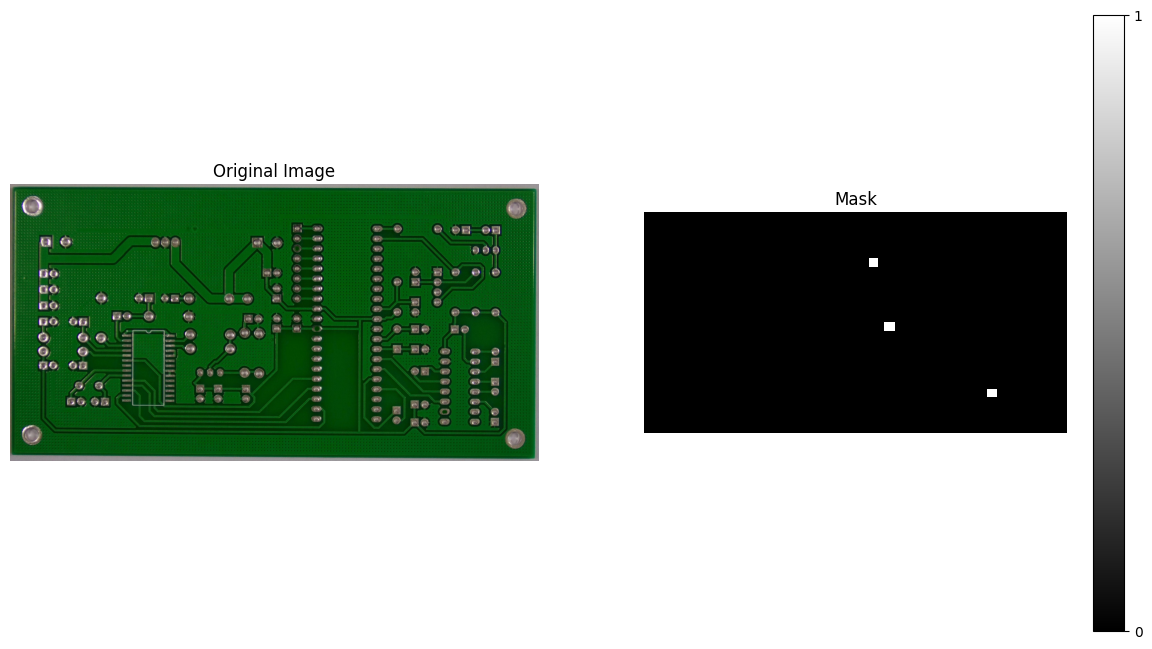

마스크 내 고유값 확인: [  0 255]


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# 경로 설정
image_path = "./PCB_Dataset/train/images/01_missing_hole_01_jpg.rf.cc62014c9acc2a192dfb2fafc3f42a42.jpg"

# 마스크 경로 생성
base, ext = os.path.splitext(image_path)
mask_path = base + "_mask.png"

def check_data_binary(img_p, mask_p):
    # 파일 존재 확인
    if not os.path.exists(img_p) or not os.path.exists(mask_p):
        print("파일이 없습니다.")
        return

    # 이미지 , 마스크 로드
    img = cv2.imread(img_p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    
    # 원본 이미지
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    im = ax[1].imshow(mask, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    ax[1].set_title("Mask")
    ax[1].axis('off')
    
    cbar = plt.colorbar(im, ax=ax[1], ticks=[0, 1])
    cbar.ax.set_yticklabels(['0', '1']) 

    plt.show()
    
    print(f"마스크 내 고유값 확인: {np.unique(mask)}") 

# 실행
check_data_binary(image_path, mask_path)